In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [17]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(1, 20)
        self.hidden_layer2 = nn.Linear(20, 20)
        self.hidden_layer3 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)
        
    def forward(self, y):
        y = torch.tanh(self.hidden_layer1(y))
        y = torch.tanh(self.hidden_layer2(y))
        y = torch.tanh(self.hidden_layer3(y))
        y = self.output_layer(y)
        return y
    
    def U(self, y):
        return (self(y) - self(-y)) / 2


In [18]:
def Loss(model, y, l):
    y.requires_grad = True
    U = model.U(y)
    
    U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
    
    # Equation loss
    f = -l * U + ((1 + l) * y + U) * U_y
    
    # Condition loss U(-2) = 1
    g = model.U(torch.tensor([-2.0])) - 1
    
    equation_loss = torch.mean(f**2)
    condition_loss = torch.mean(g**2)
    
    total_loss = equation_loss + condition_loss
    return total_loss

In [19]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lam = 0.4  

num_epochs = 10000
y_data = torch.linspace(-3, 3, 100).view(-1, 1)  # Example data for y

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = Loss(model, y_data, lam)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.9291194081306458
Epoch 1000, Loss: 6.887269410071895e-05
Epoch 2000, Loss: 2.9629713026224636e-05
Epoch 3000, Loss: 8.788469131104648e-06
Epoch 4000, Loss: 1.733612521093164e-06
Epoch 5000, Loss: 6.921698627593287e-07
Epoch 6000, Loss: 3.717358367794077e-07
Epoch 7000, Loss: 2.1646938819230854e-07
Epoch 8000, Loss: 1.6907316080505552e-07
Epoch 9000, Loss: 8.423231747656246e-07


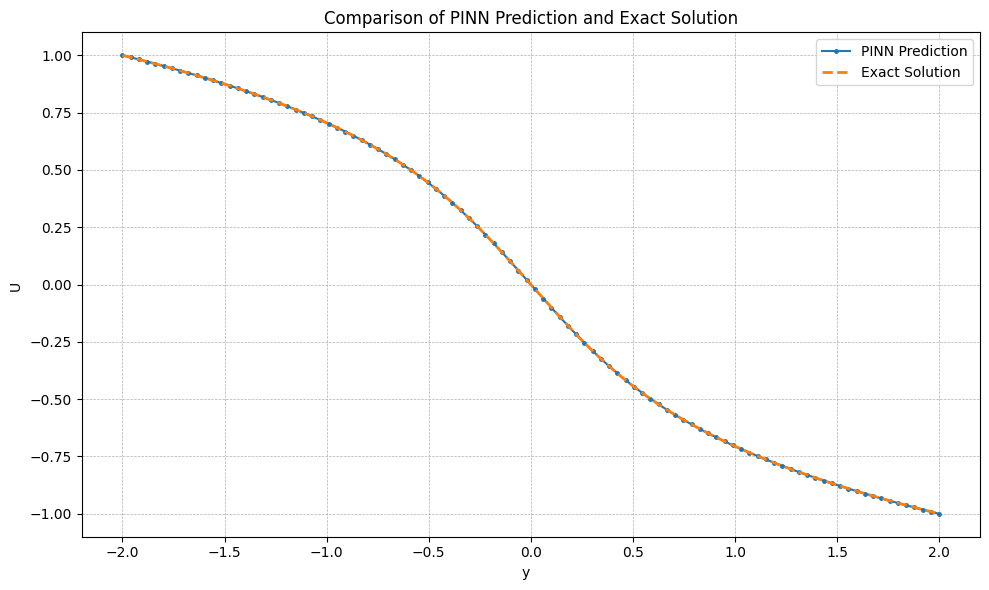

In [50]:
# For test purpose
y_test = torch.linspace(-2, 2, 100).view(-1, 1)
U_pred = model.U(y_test)
U_pred = U_pred.detach().numpy()

# Using implicit formula to get true solution
U_positive = np.linspace(0, 1, 100)
y_true = np.array([+U_positive + U_positive**(1 + 1/lam), -U_positive - U_positive**(1 + 1/lam)]).flatten()
order = y_true.argsort()
U_sorted = np.array([-U_positive, U_positive]).flatten()[order]
y_sorted = y_true[order]
plt.figure(figsize=(10, 6))
plt.plot(y_test, U_pred, '.-', label='PINN Prediction', color='#1f77b4', markersize=5)  
plt.plot(y_sorted, U_sorted, label='Exact Solution', color='#ff7f0e', linestyle='--', linewidth=2) 

plt.title('Comparison of PINN Prediction and Exact Solution')
plt.xlabel('y  ')
plt.ylabel('U ')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

plt.show()